In [1]:
import sys
from urllib.request import urlretrieve

# Check if Colab is still running Python 3.6.x:
if not (sys.version_info.major == 3 and sys.version_info.minor == 6):
    print("This notebook is specific to Python 3.6.x")
    sys.exit(1)

# Download Miniconda installer, specifically the last version targeting 3.6.x:
urlretrieve("https://repo.anaconda.com/miniconda/Miniconda3-4.5.4-Linux-x86_64."
            "sh", filename = "miniconda.sh")
# Install Miniconda:
!bash miniconda.sh -bfp /usr/local/
# Use conda to install Psi4:
!conda install -c psi4 psi4 python=3.6 -y

# Add conda package install location to PATH so we can import psi4 in Python:
sys.path.append("/usr/local/lib/python3.6/site-packages")

PREFIX=/usr/local
installing: python-3.6.5-hc3d631a_2 ...
Python 3.6.5 :: Anaconda, Inc.
installing: ca-certificates-2018.03.07-0 ...
installing: conda-env-2.6.0-h36134e3_1 ...
installing: libgcc-ng-7.2.0-hdf63c60_3 ...
installing: libstdcxx-ng-7.2.0-hdf63c60_3 ...
installing: libffi-3.2.1-hd88cf55_4 ...
installing: ncurses-6.1-hf484d3e_0 ...
installing: openssl-1.0.2o-h20670df_0 ...
installing: tk-8.6.7-hc745277_3 ...
installing: xz-5.2.4-h14c3975_4 ...
installing: yaml-0.1.7-had09818_2 ...
installing: zlib-1.2.11-ha838bed_2 ...
installing: libedit-3.1.20170329-h6b74fdf_2 ...
installing: readline-7.0-ha6073c6_4 ...
installing: sqlite-3.23.1-he433501_0 ...
installing: asn1crypto-0.24.0-py36_0 ...
installing: certifi-2018.4.16-py36_0 ...
installing: chardet-3.0.4-py36h0f667ec_1 ...
installing: idna-2.6-py36h82fb2a8_1 ...
installing: pycosat-0.6.3-py36h0a5515d_0 ...
installing: pycparser-2.18-py36hf9f622e_1 ...
installing: pysocks-1.6.8-py36_0 ...
installing: ruamel_yaml-0.15.37-py36h14c

In [2]:
import numpy as np
import psi4

# Let Psi4 use 10/12 GB of memory on the typical Colab:
psi4.set_memory("10 GB")

# Create a bunch of interatomic distances, in angstroms, where we would like
# to evaluate the energy of our Argon dimer:
distances = np.linspace(3, 6, 16)

# Choose a reasonable basis set to represent the wavefunction:
psi4.set_options({"basis": "aug-cc-pVTZ"})

In [3]:
# Let's first compute the approximate energy of an isolated Argon atom, that is
# the energy of 18 electrons bound to a +18e point charge:
monomer = psi4.geometry("Ar")

# We'll use a modern, general-purpose density functional theory (DFT)
# functional, developed at Berkeley in the Martin Head-Gordon group:
monomer_energy = psi4.energy("wB97X-V", molecule = monomer)
# Unfortunately, disk space is very limited on Colab, so we have to make sure
# temporary files are immediately deleted after each Psi4 run:
psi4.core.clean()

# Convert resulting energy from Hartrees to kJ/mol:
monomer_energy *= psi4.constants.hartree2kJmol

In [4]:
results = []

# Loop over each distance in distances:
for distance in distances:
    # Create two argon atoms separated by this distance:
    dimer = psi4.geometry("""
    Ar
    Ar 1 """ + str(distance))
    # Compute the energy of this system, convert it to kJ/mol, and subtract
    # twice the isolated Ar energy:
    results.append(psi4.constants.hartree2kJmol
                   * psi4.energy("wB97X-V", molecule = dimer, bsse = "CP")
                   - 2 * monomer_energy)
    psi4.core.clean()

Text(0, 0.5, 'dimer energy - 2 * monomer energy (kJ/mol)')

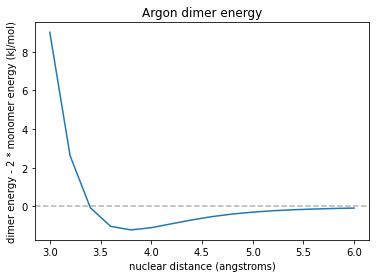

In [5]:
# Instruct IPython to display matplotlib plots directly in the notebook output:
%matplotlib inline
from matplotlib import pyplot as plt

# Create a horizontal line at y = 0 for reference:
plt.axhline(0, linestyle = "dashed", color = "black", alpha = 0.3)
# Plot the energies and label the plot axes:
plt.plot(distances, results)
plt.title("Argon dimer energy")
plt.xlabel("nuclear distance (angstroms)")
plt.ylabel("dimer energy - 2 * monomer energy (kJ/mol)")

In [6]:
# We can also try to decompose the interaction energy into different
# components, in this case using symmetry-adapted perturbation theory (SAPT).
# For the method used here, we'll need to calculate a correction factor, which
# turns out to be the sum of the ionization energy and the highest occupied
# molecular orbital (HOMO) energy.

# Experimental value from NIST Chemistry WebBook:
Ar_ionization_energy = 15.759 / psi4.constants.hartree2ev

# Compute the isolated Ar energy and store the resulting wavefunction using the
# PBE0 density functional, which is traditionally used for SAPT(DFT):
monomer_energy, monomer_wavefunction = psi4.energy("PBE0",
                                                   molecule = monomer,
                                                   return_wfn = True)
psi4.core.clean()

# Grab the HOMO energy from this wavefunction object:
HOMO_energy = monomer_wavefunction.epsilon_a_subset("AO", "ALL").\
                  np[monomer_wavefunction.nalpha() - 1]

# Store and print the correction factor:
GRAC_shift = Ar_ionization_energy + HOMO_energy
print("GRAC shift: " + str(GRAC_shift) + " hartrees")

GRAC shift: 0.13853566570003517 hartrees


In [7]:
results_sapt = []
results_sapt_decomposed = []

# Specify the correction factor and density functional for SAPT:
psi4.set_options({"basis": "aug-cc-pVTZ", "SAPT_DFT_functional": "PBE0",
                  "SAPT_DFT_GRAC_shift_a": GRAC_shift,
                  "SAPT_DFT_GRAC_shift_b": GRAC_shift})

for distance in distances:
    psi4.set_module_options("SCF", {"reference": "RHF"})
    dimer = psi4.geometry("""
    Ar
    --
    Ar 1 """ + str(distance))
    # Store the total interaction energy, converted to kJ/mol:
    results_sapt.append(psi4.constants.hartree2kJmol
                        * psi4.energy("SAPT(DFT)", molecule = dimer))
    # Also store the individual energy components from this decomposition:
    results_sapt_decomposed.append([psi4.constants.hartree2kJmol
                                    * psi4.core.variable(' '.join(["SAPT", term,
                                                                   "ENERGY"]))
                                    for term in
                                    ["ELST", "EXCH", "DISP", "IND"]])
    psi4.core.clean()

(-4.0, 8.0)

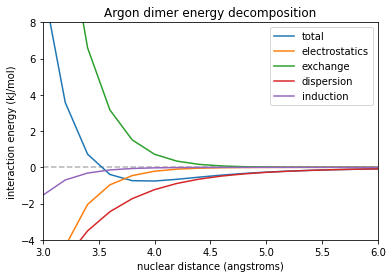

In [8]:
# Again plot a line at y = 0 for reference, but exclude it from the legend:
plt.axhline(0, linestyle = "dashed", color = "black", alpha = 0.3,
            label='_nolegend_')
plt.plot(distances, results_sapt)
for i in range(4):
    plt.plot(distances, np.array(results_sapt_decomposed)[:,i])
plt.title("Argon dimer energy decomposition")
plt.xlabel("nuclear distance (angstroms)")
plt.ylabel("interaction energy (kJ/mol)")

# Create a legend:
plt.legend(["total", "electrostatics", "exchange", "dispersion", "induction"])

# Focus the plot on just the interesting region of the decomposition:
plt.xlim(3, 6)
plt.ylim(-4, 8)

Optimized parameters:
depth: 1.050768652916631 kJ/mol
r_minimum: 3.7973463229590854 angstroms


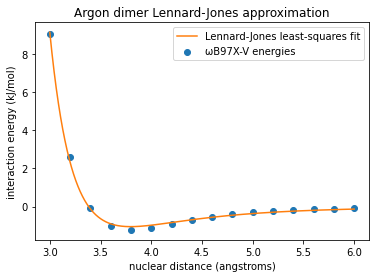

In [9]:
from scipy.optimize import curve_fit

# For simulations, a Lennard-Jones potential is often used to approximate the
# exchange (Pauli repulsion) and dispersion (attractive) interactions. Let's
# define a function to compute the Lennard-Jones potential:
def lennard_jones(r, depth, r_minimum):
    return depth * ((r_minimum / r) ** 12 - 2 * (r_minimum / r) ** 6)

# Fit depth and r_minimum parameters by minimizing the sum of squared errors:
parameters_optimized, parameters_covariance = curve_fit(lennard_jones,
                                                        distances,
                                                        results,
                                                        p0 = (1, 4))

print("Optimized parameters:")
print("depth: " + str(parameters_optimized[0]) + " kJ/mol")
print("r_minimum: " + str(parameters_optimized[1]) + " angstroms")

# Create a bunch of points at which to evaluate the function for plotting:
xvals = np.linspace(3, 6, 10000)
# And actually evalute the function value at each point in the NumPy array:
yvals = lennard_jones(xvals, *parameters_optimized)

# We'll plot the energies and the fitted Lennard-Jones potential together
# to get an idea of how well it approximates the Argon-Argon interaction:
plt.scatter(distances, results, label = "ωB97X-V energies")
plt.plot(xvals, yvals, color = 'C1', label = "Lennard-Jones least-squares fit")
plt.title("Argon dimer Lennard-Jones approximation")
plt.xlabel("nuclear distance (angstroms)")
plt.ylabel("interaction energy (kJ/mol)")
plt.legend()